## Generate New Files

* Given a template and a definition of the variables, generate a set of new files

In [2]:
from pathlib import Path
import re
from pyDOE import lhs
import numpy as np
import pandas as pd

from scipy import stats

class TemplateProcessor:
    def __init__(self, template_path, verbose=False, output_file_path=None, variables_table_path=None, all_uniform=False, n_samples=0):
        self.template_path = Path(template_path)
        if not self.template_path.exists():
            raise FileNotFoundError(f"Template file '{self.template_path}' not found.")
        
        self._verbose = verbose
        self._all_uniform = all_uniform

        self._valid_distributions = {
            'uniform':      {'parameters':2, 'description':('minimum','maximum'), 'types':['int','float']},
            'normal':       {'parameters':2, 'description':('mean','std_var'), 'types':['float']},
            'truncnormal':  {'parameters':4, 'description':('mean','std_var','minimum','maximum'), 'types':['float']},
            'lognormal':    {'parameters':2, 'description':('mean','std_var'), 'types':['float']},
            'triangular':   {'parameters':3, 'description':('minimum','maximum','most_likelly'), 'types':['float']},
            'constant':     {'parameters':1, 'description':('value',), 'types':['int','float','str']},
            'categorical':  {'parameters':2, 'description':('values_list','probabilities_list'), 'types':['int','float','str']},
            'table':        {'parameters':0, 'description':('no parameters',), 'types':['str']}
        }
        # std_dev from mean to define limits of normal distribution variables when using option all_uniform=True
        self._normal_limits_as_uniform = 2.

        self.variables_raw = self._extract_raw_text()
        self.variables = self._parse_variables()

        if variables_table_path is not None:
            self.set_variables_table(variables_table_path)

        self.experiments_table = None
        self._current_distribution = None
        self._n_samples = n_samples
        if output_file_path is not None:
            self.set_output_file(output_file_path)
            self.generate_experiments(self._n_samples)
            self.create_new_files()

    def __str__(self):
        return str(self.variables)

    def list_valid_distributions(self):
        for k,v in self._valid_distributions.items():
            print(f"{k} distribution - parameters: {', '.join(v['description'])}; valid type(s): {', '.join(v['types'])}")

    def _extract_contents(self, text, open=r'\(', close=r'\)'):
        pattern = f'{open}(.*?){close}'
        matches = re.findall(pattern, text)
        return matches
    
    def _custom_split(self, text, sep=',', open='{', close='}'):
        result = []
        current_token = ''
        paren_count = 0

        for char in text:
            if char == sep and paren_count == 0:
                result.append(current_token.strip())
                current_token = ''
            elif char == open:
                paren_count += 1
                current_token += char
            elif char == close:
                paren_count -= 1
                current_token += char
            else:
                current_token += char

        result.append(current_token.strip())
        return result
    
    def _extract_raw_text(self):
        variables_raw = []
        with open(self.template_path, 'r') as file:
            for line_num, line in enumerate(file, start=1):              
                if line.count(r'<\var>') != line.count('<var>'):
                    raise ValueError(f"Unclosed <\\var> <var> at line {line_num}.")
                parts = self._extract_contents(text=line, open=r'<\\var>', close=r'<var>')
                if len(parts) > 0:
                    for part in parts:
                        var = part.strip()
                        if var == '':
                            raise ValueError(f"Empty variable name at line {line_num}.")
                        variables_raw.append(var)
        return variables_raw

    def _transform_variable(self, variable, variable_type):
        if isinstance(variable, list):
            var = list()
            for i in range(len(variable)):
                var.append(self._transform_variable(variable=variable[i], variable_type=variable_type))
                if var[-1] is None:
                    return None
            return var
        else:                
            try:
                var_type = {'int': int,
                            'str': str,
                            'float': float}[variable_type.strip().lower()]
                return var_type(variable)
            except (ValueError, TypeError, NameError):
                return None
            
    def _parse_distribution(self, text, var_type):
        if text is None:
            if self._verbose:
                print("  No distribution provided. Will assume 'table'.")
            return 'table', list()

        parameters = self._custom_split(text)
        distribution = parameters[0].lower()
        if distribution not in self._valid_distributions:
            raise ValueError(f"Invalid distribution: '{distribution}'.")
        parameters = parameters[1:]
        if len(parameters) != self._valid_distributions[distribution]['parameters']:
            raise ValueError(f"Invalid number of parameters for distribution '{distribution}'. Expected {self._valid_distributions[distribution]['parameters']}, found {len(parameters)}.")

        if var_type is not None:
            if var_type not in self._valid_distributions[distribution]['types']:
                raise ValueError(f"Invalid type ({var_type}) for distribution '{distribution}'. Valid option(s): {', '.join(self._valid_distributions[distribution]['types'])}.")
            
            if distribution == 'categorical':
                param_list = parameters[0].lstrip('{').rstrip('}').split(',')
            else:
                param_list = parameters

            for i in range(len(param_list)):
                new_value = self._transform_variable(variable=param_list[i], variable_type=var_type)
                if new_value is None:
                    raise ValueError(f"Parameters for distribution '{distribution}' must be of type {var_type}. Cannot transform '{param_list[i]}'.")
                param_list[i] = new_value
    
            if distribution == 'categorical':
                parameters[0] = param_list
            else:
                parameters = param_list

        if distribution == 'categorical':
            param_list = parameters[1].lstrip('{').rstrip('}').split(',')
            if len(parameters[0]) != len(param_list):
                raise ValueError(f"Inconsistent number of values in distribution '{distribution}'. Values found: {len(parameters[0])}, associated probabilities: {len(param_list)}.")
            for i in range(len(param_list)):
                new_value = self._transform_variable(variable=param_list[i], variable_type='float')
                if new_value is None:
                    raise ValueError(f"Probabilities for distribution '{distribution}' must be of type float. Cannot transform '{param_list[i]}'.")
                param_list[i] = new_value
            s = sum(param_list)
            cum_list = [sum(param_list[:i+1])/s for i in range(len(param_list))]
            parameters[1] = cum_list

        return distribution, parameters
    
    def _check_variable_type(self, default, distribution, parameters):
        var_type = None
        for test_type in self._valid_distributions[distribution]['types']:
            if var_type is None:
                var_type = test_type
    
                if default is not None:
                    default_mod = self._transform_variable(variable=default, variable_type=test_type)
                    if default_mod is None:
                        var_type = None
                    else:
                        default = default_mod

                param_out = list()
                for param in parameters:
                    if var_type is not None:
                        param_out.append(self._transform_variable(variable=param, variable_type=var_type))
                        if param_out[-1] is None:
                            var_type = None
                
                if var_type is not None:
                    parameters = param_out

                    if self._verbose:
                        print(f"  No type provided. Will assume '{var_type}'.")
                
        return default, distribution, parameters, var_type

    def _parse_variable_options(self, text):
        default = None
        var_type = None

        distribution_text = self._extract_contents(text=text, open=r'\(', close=r'\)')
        if len(distribution_text) > 1:
            raise ValueError(f"Bad distribution options format in: '{text}'. Only one distribution with ( and ) can be defined.")

        options = self._custom_split(text=text, open='(', close=')')
        if len(distribution_text) == 1:
            if '(' not in options[-1] or ')' not in options[-1]:
                raise ValueError(f"Distribution options with ( and ) must be the last information in: '{options}'.")
            options = options[:-1]
            distribution_text = distribution_text[0].strip()
        else:
            distribution_text = None

        if len(options) > 2:
            raise ValueError(f"Bad options format in: '{options}'. Too many options.")
        elif len(options) > 0:
            if len(options) > 1 or options[0] != '':
                default = options[-1].strip()
                if len(options) == 2:
                    var_type = options[0].strip()
                    default = self._transform_variable(variable=default, variable_type=var_type)
                    if default is None:
                        raise ValueError(f"Default value ({options[-1]}) must be of the defined type ({var_type}).")

        distribution, parameters = self._parse_distribution(distribution_text, var_type)

        if var_type is None:
            default, distribution, parameters, var_type = self._check_variable_type(default, distribution, parameters)
        if var_type is None:
            raise ValueError(f"Couldn't find the variable type based on provided data: '{text}'. Possible type(s) for {distribution} are: {', '.join(self._valid_distributions[distribution]['types'])}.")

        return {'active': True, 'distribution': distribution, 'parameters': parameters, 'default': default, 'type': var_type}

    def _parse_key(self, text):
        key = text.split('[')[0].strip()
        if len(key) == 0:
            raise ValueError(f"Undefined variable name in: '{text}'.")
        return key

    def _parse_options(self, text):
        options = self._extract_contents(text=text, open=r'\[', close=r'\]')
        if len(options) > 1:
            raise ValueError(f"Bad options format in: '{text}'. Only one list with [ and ] can be defined.")

        if len(options) == 1:
            options_dict = self._parse_variable_options(options[0])
        else:
            options_dict = self._parse_variable_options('')

        return options_dict

    def _parse_variables(self):
        # General pattern: Variable[type, default, (distribution, par1, par2)]
        variables = {}
        repetition = list()
        for text in self.variables_raw:
            if self._verbose:
                print(f'Command found: {text}')
            key = self._parse_key(text)
            if key in variables:
                if self._verbose and key not in repetition:
                    print(f'  key {key} found more than once. Ignoring options in repetitions.')
                    repetition.append(key)
            else:
                options = self._parse_options(text)
                variables[key] = options
                if self._verbose:
                    print(f'  key: {key}')
                    print(f'  options: {options}')
        return variables

    def set_output_file(self, output_file_path):
        if output_file_path is None:
            self.output_file_path = None
        else:
            try:
                self.output_file_path = Path(output_file_path)
            except (ValueError, TypeError, NameError):
                self.output_file_path = None
                raise ValueError(f"Invalid file path: {str(output_file_path)}")

    def set_variables_table(self, variables_table_path):
        if not Path(variables_table_path).exists():
            print(f"CSV file '{variables_table_path}' not found.")
        else:
            try:
                df = pd.read_csv(variables_table_path, skipinitialspace=True)
                for key in df.columns:
                    if key not in self.variables:
                        print(f"Variable '{key}' not found in template. Will ignore data.")
                        continue
                    if self.variables[key]['distribution'] != 'table':
                        print(f"Variable '{key}' already has a distribution. Will ignore data.")
                        continue
                    self.variables[key]['values'] = list(df[key])
            except (ValueError, TypeError, NameError):
                print(f'Error reading variables table file: {variables_table_path}')

    def _check_generate_experiments(self, n_samples=0):
        tables_n_values = list()
        for data in self.variables.values():
            if data.get('distribution', False) == 'table':
                tables_n_values.append(len(data.get('values', [])))

        if len(tables_n_values) > 0:
            if not min(tables_n_values) == max(tables_n_values):
                print(f"Number of entries in 'table' variables is inconsistent, ranging from {min(tables_n_values)} to {max(tables_n_values)}. Cannot continue.")
                return None         
            tables_n_values = tables_n_values[0]
            if tables_n_values == 0:
                print("No values found for 'table' variables. Cannot continue.")
                return None
        else:
            tables_n_values = n_samples

        if n_samples < 1 and tables_n_values > 0:
            n_samples = tables_n_values
        elif n_samples < 1:
            print(f"Requested sample size ({n_samples}) is smaller than minimum (1). Cannot continue.")
            return None
        elif tables_n_values != n_samples:
            print(f"Number of values in 'table' variables ({tables_n_values}) is different from the requested sample size ({n_samples}). Cannot continue.")
            return None
        
        return n_samples

    def _InvCDF(self, probability, data, all_uniform):
        if min(probability) < 0:
            raise ValueError("Probability lower than zero!")
        if max(probability) > 1:
            raise ValueError("Probability larger than one!")

        distribution = data['distribution']
        parameters = data['parameters']
        
        if distribution == 'constant':
            return parameters[0]
        
        elif distribution == 'categorical':
            if all_uniform:
                n = len(parameters[0])
                p_cum_list = [(i+1) / n for i in range(n)]
            else:
                p_cum_list = parameters[1]

            def cat_prob(x):
                for i, p in enumerate(p_cum_list):
                    if p >= x:
                        return parameters[0][i]
                raise ValueError("Error in categorical probabilities!")
            vec_cat_prob = np.vectorize(cat_prob)
            return vec_cat_prob(probability)

        elif distribution == 'uniform' or (distribution == 'triangular' and all_uniform):
            loc = parameters[0]
            scale = parameters[1] - parameters[0]
            if isinstance(loc, int) and isinstance(scale, int):
                return np.int32(stats.randint.ppf(probability, low=loc, high=loc+scale+1))
            else:
                return stats.uniform.ppf(probability, loc=loc, scale=scale)
            
        elif distribution == 'triangular':
            loc = parameters[0]
            scale = parameters[1] - parameters[0]
            c = (parameters[2] - parameters[0]) / scale
            return stats.triang.ppf(probability, c, loc=loc, scale=scale)
            
        elif distribution == 'normal':
            mean = parameters[0]
            std_dev = parameters[1]
            if all_uniform:
                loc = mean - std_dev * self._normal_limits_as_uniform
                scale = 2 * std_dev * self._normal_limits_as_uniform
                return stats.uniform.ppf(probability, loc=loc, scale=scale)
                # return a + probability * (b - a)
            else:
                return stats.norm.ppf(probability, loc=mean, scale=std_dev)
        
        elif distribution == 'truncnormal':
            mean = parameters[0]
            std_dev = parameters[1]
            a = parameters[2]
            b = parameters[3]
            if all_uniform:
                return stats.uniform.ppf(probability, loc=a, scale=b)
                # return a + probability * (b - a)
            else:
                return stats.truncnorm.ppf(probability, (a - mean) / std_dev, (b - mean) / std_dev, loc=mean, scale=std_dev)
        
        elif distribution == 'lognormal':
            mean = parameters[0]
            std_dev = parameters[1]
            if all_uniform:
                loc = mean - std_dev * self._normal_limits_as_uniform
                scale = 2 * std_dev * self._normal_limits_as_uniform
                return stats.uniform.ppf(probability, loc=loc, scale=scale)
            else:
                return stats.lognorm.ppf(probability, s=std_dev, scale=np.exp(mean))
        
        raise ValueError(f"Unknown distribution: {distribution}.")
        
    def set_variable_active(self, variable, active=True):
        if variable not in self.variables:
            raise ValueError(f"Unknown variable: {variable}.")
        if not active and self.variables[variable]['default'] is None:
            raise ValueError(f"Cannot deactivate a variable without a default value: {variable}.")
        self.variables[variable]['default'] = active

    def generate_experiments(self, n_samples=0, all_uniform=None):
        if self._verbose:
            print('Cheking parameters')
        n_samples = self._check_generate_experiments(n_samples=n_samples)
        if n_samples < 1:
            self.experiments_table = None
            return
        
        if all_uniform is None:
            all_uniform = self._all_uniform

        if self._verbose:
            print('Building experiments')
        samples = lhs(len(self.variables), samples=n_samples, criterion='maximin', iterations=min(100, max(1, int(1e6*np.power(10, -2.)))))

        if self._verbose:
            print('Calculating inverse CDF')
        df = pd.DataFrame()
        for column_index, var in enumerate(self.variables):
            data = self.variables[var]
            if self._verbose:
                print(f'   {var}: {data['distribution']}')
            if not data['active']:
                df[var] = [data['default']] * n_samples
            elif data['distribution'] == 'table':
                df[var] = data['values']
            else:
                df[var] = self._InvCDF(samples[:, column_index], data, all_uniform)
        self.experiments_table = df
        
    def _create_new_file(self, output_file_path, values, text):
        new_text = text
        for var in self.variables:
            pattern = f'<\\\\var>{var}[^<]+<var>'
            value = self._transform_variable(values[var], self.variables[var]['type'])
            new_text = re.sub(pattern, str(value), new_text)
        with open(output_file_path, 'w') as f:
            f.write(new_text)

    def create_new_files(self, output_file_path=None):
        if output_file_path is not None:
            self.set_output_file(output_file_path)
        if self.output_file_path is None:
            print('Output file not defined. Cannot continue.')
            return
        if self.experiments_table is None:
            self.generate_experiments()
            if self.experiments_table is None:
                print('Experiments table could not be created. Cannot continue.')
                return
        
        with open(self.template_path, 'r') as f:
            text = f.read()
        
        for index, row in self.experiments_table.iterrows():
            new_file_path = self.output_file_path.with_name(f"{self.output_file_path.stem}_{index}{self.output_file_path.suffix}")
            self._create_new_file(new_file_path, row.to_dict(), text)

# template = TemplateProcessor(template_path=r'..\template\no_errors_distributions.dat',
                            #  verbose=True)
# template.generate_experiments(1000)
# print(template.experiments_table)

# Tests

### Common Functions

In [65]:
import tempfile

def process_temporary_file(text, verbose=False, variables_df=None, output_file_path=None, all_uniform=False, n_samples=0):
    try:
        with tempfile.NamedTemporaryFile(mode='w', delete=False) as temp_file:
            temp_file.write(text)
            temp_file_path = Path(temp_file.name)

        temp_csv_file_path = None
        if variables_df is not None:
            with tempfile.NamedTemporaryFile(suffix='.csv', delete=False) as temp_csv_file:
                variables_df.to_csv(temp_csv_file.name, index=False)
                temp_csv_file_path = Path(temp_csv_file.name)
        
        return TemplateProcessor(template_path=temp_file_path, verbose=verbose, variables_table_path=temp_csv_file_path, output_file_path=output_file_path, all_uniform=all_uniform, n_samples=n_samples)       

    finally:
        temp_file_path.unlink()
        if variables_df is not None:
            temp_csv_file_path.unlink()

In [66]:
import matplotlib.pyplot as plt

def plot_histogram(data, bins=30, title='Histogram of Data'):
    plt.figure(figsize=(4, 2))
    plt.hist(data, bins=bins, density=True, alpha=0.75)
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

## No Errors Test

In [67]:
text = [
    r"** Some comments",
    r"No variables to read",
    r"The first variable is <\var>var1<var>",
    r"Second is <\var>var2[12]<var> is ok",
    r"<\var>var3[int,42]<var> is an integer",
    r"Now a normal distribution <\var>var4[float,0.5,(normal,0, 2.5)]<var> with mean 0 and variance 2.5.",
    r"Another a normal distribution <\var>var5[0.5,(normal,0, 2.5)]<var> with mean 0 and variance 2.5.",
    r"just a line",
    r"",
    r"Two variables: <\var>var6[float,7.,(categorical,{1,3,7,-12},{0.2,0.15,0.25,0.400})]<var>",
    r"",
    r"Distribution with explicit type: <\var>var7[(normal,0, 2.5)]<var>",
    r"Distribution with explicit type: <\var>var8[(uniform,0, 12)]<var>",
    r"Distribution with explicit type: <\var>var9[(uniform,0., 12.)]<var>",
    r"Distribution with explicit type: <\var>var10[(constant,0)]<var>",
    r"",
    r"The last line with no variables."
    ]

template = process_temporary_file(text='\n'.join(text), verbose=False)

In [68]:
template.variables

{'var1': {'active': True,
  'distribution': 'table',
  'parameters': [],
  'default': None,
  'type': 'str'},
 'var2': {'active': True,
  'distribution': 'table',
  'parameters': [],
  'default': '12',
  'type': 'str'},
 'var3': {'active': True,
  'distribution': 'table',
  'parameters': [],
  'default': 42,
  'type': 'int'},
 'var4': {'active': True,
  'distribution': 'normal',
  'parameters': [0.0, 2.5],
  'default': 0.5,
  'type': 'float'},
 'var5': {'active': True,
  'distribution': 'normal',
  'parameters': [0.0, 2.5],
  'default': 0.5,
  'type': 'float'},
 'var6': {'active': True,
  'distribution': 'categorical',
  'parameters': [[1.0, 3.0, 7.0, -12.0], [0.2, 0.35, 0.6, 1.0]],
  'default': 7.0,
  'type': 'float'},
 'var7': {'active': True,
  'distribution': 'normal',
  'parameters': [0.0, 2.5],
  'default': None,
  'type': 'float'},
 'var8': {'active': True,
  'distribution': 'uniform',
  'parameters': [0, 12],
  'default': None,
  'type': 'int'},
 'var9': {'active': True,
  'dis

## Import Table

In [69]:
text = [
    r"Variable #1: <\var>var1[17,(table)]<var>.",
    r"Variable #2: <\var>var2<var>.",
    r"Variable #3+4: <\var>var3<var> + <\var>var4<var>.",
    r"Variable #1: <\var>var1<var> & <\var>var1<var>."
    ]

df = pd.DataFrame()
df['var1'] = [1, 2, 3, 4]
df['var2'] = [4, 3, 2, 1]
df['var3'] = ['a', 'b', 'c', 'd']
df['var4'] = [10, -20, 300, 404]

template = process_temporary_file(text='\n'.join(text), verbose=False, variables_df=df)
for k in template.variables:
    print(f"{k}: {str(template.variables[k]['values'])}")


var1: [1, 2, 3, 4]
var2: [4, 3, 2, 1]
var3: ['a', 'b', 'c', 'd']
var4: [10, -20, 300, 404]


## Distributions

uniform 1-10


  mean: 5.5
  std_dev: 2.8722813232690143
  min: 1
  max: 10



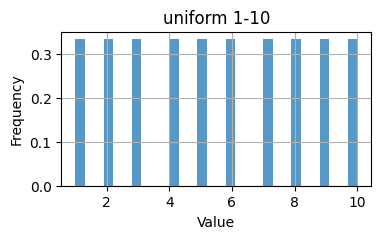

uniform 0-1
  mean: 0.4999782460279637
  std_dev: 0.2887939567482262
  min: 0.00158163524659806
  max: 0.9953750129574362



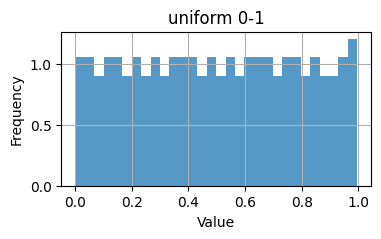

normal 0, 1
  mean: -0.001107582657751558
  std_dev: 1.000556066139512
  min: -2.9452418638142217
  max: 2.8466842181608154



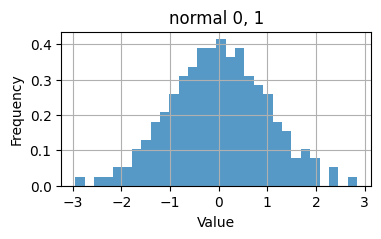

normal 10, 2
  mean: 9.999002129696475
  std_dev: 2.0052715901462164
  min: 3.950620536239337
  max: 15.858833224893718



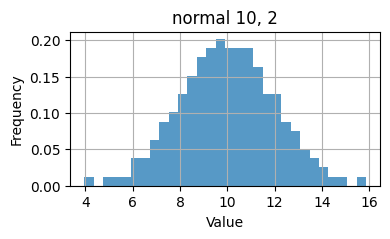

truncnormal 0, 1, +-2
  mean: 0.0003518591035527541
  std_dev: 0.8803393532162088
  min: -1.9738203928627556
  max: 1.981333378604957



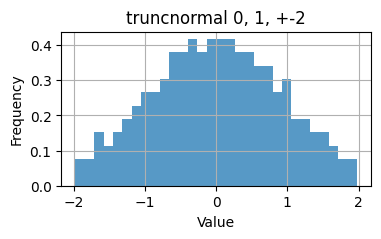

lognormal 0, 1
  mean: 1.6176515678597376
  std_dev: 1.879840097640591
  min: 0.03213489658658605
  max: 13.895921889061194



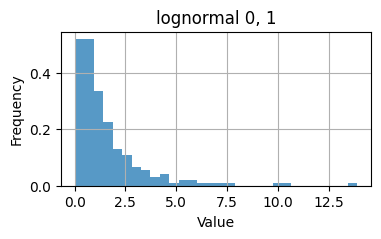

triangular 0,3,1
  mean: 1.332937761309949
  std_dev: 0.6230987673707006
  min: 0.05872381000579945
  max: 2.8345018618223947



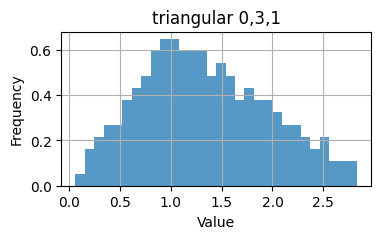

constant 2.0
  mean: nan
  std_dev: nan
  min: nan
  max: nan



c:\Users\tiago.LENOVO-I7\Unicamp\PHD\simpython\.venv\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


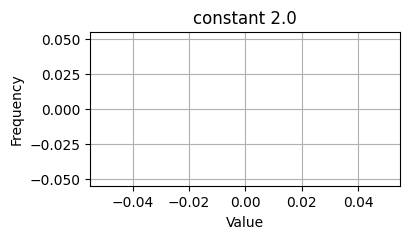

categorical 1/1/2/6
  mean: 3.3
  std_dev: 1.004987562112089
  min: 1
  max: 4



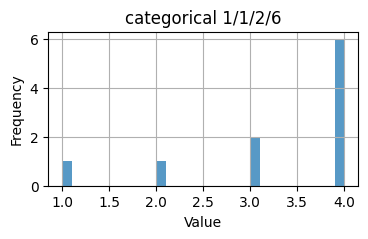

In [73]:
distributions_list = {
    'uniform 1-10':r'<\var>var[int,1,(uniform,1,10)]<var>',
    'uniform 0-1':r'<\var>var[float,1,(uniform,0,1)]<var>',
    'normal 0, 1':r'<\var>var[float,1,(normal,0,1)]<var>',
    'normal 10, 2':r'<\var>var[float,1,(normal,10,2)]<var>',
    'truncnormal 0, 1, +-2':r'<\var>var[float,1,(truncnormal,0,1,-2, 2)]<var>',
    'lognormal 0, 1':r'<\var>var[float,1,(lognormal,0,1)]<var>',
    'triangular 0,3,1':r'<\var>var[float,1,(triangular,0,3,1)]<var>',
    'constant 2.0':r'<\var>var[float,1,(constant,2)]<var>',
    'categorical 1/1/2/6':r'<\var>var[int,1,(categorical,{1,2,3,4},{0.1,0.1,0.2,0.6})]<var>',
}

for k,v in distributions_list.items():
    print(f'{k}')
    template = process_temporary_file(text=v, verbose=False)
    template.generate_experiments(200)
    data = template.experiments_table['var']
    print(f'  mean: {np.mean(data)}')
    print(f'  std_dev: {np.std(data)}')
    print(f'  min: {np.min(data)}')
    print(f'  max: {np.max(data)}')
    print()
    plot_histogram(data=data, title=k)

## Export Files

In [76]:
text = [
    r'uniform int         = "<\var>var1[int,1,(uniform,1,10)]<var>"',
    r'uniform float       = "<\var>var2[float,1,(uniform,0,1)]<var>"',
    r'normal 0-1          = "<\var>var3[float,1,(normal,0,1)]<var>"',
    r'normal 10-2         = "<\var>var4[float,1,(normal,10,2)]<var>"',
    r'truncnormal 0-1 +-2 = "<\var>var5[float,1,(truncnormal,0,1,-2, 2)]<var>"',
    r'lognormal 0-1       = "<\var>var6[float,1,(lognormal,0,1)]<var>"',
    r'triangular 0-3-1    = "<\var>var7[float,1,(triangular,0,3,1)]<var>"',
    r'constant int        = "<\var>var8A[int,1,(constant,2)]<var>"',
    r'constant float      = "<\var>var8B[float,1,(constant,2)]<var>"',
    r'constant str        = "<\var>var8C[str,1,(constant,2)]<var>"',
    r'categorical int     = "<\var>var9A[int,1,(categorical,{1,2,3,4},{0.1,0.1,0.2,0.6})]<var>"',
    r'categorical float   = "<\var>var9B[float,1,(categorical,{1,2,3,4},{0.1,0.1,0.2,0.6})]<var>"',
    r'categorical str     = "<\var>var9C[str,1,(categorical,{1,2,3,4},{0.1,0.1,0.2,0.6})]<var>"',
]

template = process_temporary_file(text='\n'.join(text), verbose=False, output_file_path=r'.\temp\test.dat', all_uniform=False, n_samples=10)
print(template.experiments_table.head())
print()
for k in template.experiments_table:
    print(f'{k}: {type(template.experiments_table[k][0])}')

   var1      var2      var3       var4      var5      var6      var7  var8A  \
0     6  0.393158  0.644319   8.010650 -1.375124  1.270232  1.245322      2   
1     9  0.773515 -0.999138   9.571085 -0.045828  0.385900  0.802849      2   
2     1  0.138834 -0.042397  12.087205  0.365543  0.613259  0.596836      2   
3     3  0.963906 -0.733647   8.913417  1.300181  1.493043  2.079656      2   
4     4  0.648544 -1.978367   9.342885 -0.702660  0.093822  1.869142      2   

   var8B var8C  var9A  var9B var9C  
0    2.0     2      3    4.0     4  
1    2.0     2      4    3.0     3  
2    2.0     2      4    4.0     4  
3    2.0     2      1    4.0     1  
4    2.0     2      2    4.0     3  

var1: <class 'numpy.int32'>
var2: <class 'numpy.float64'>
var3: <class 'numpy.float64'>
var4: <class 'numpy.float64'>
var5: <class 'numpy.float64'>
var6: <class 'numpy.float64'>
var7: <class 'numpy.float64'>
var8A: <class 'numpy.int64'>
var8B: <class 'numpy.float64'>
var8C: <class 'str'>
var9A: <class

## Error Catching Test

In [78]:
def test_function(func):
    def wrapper(*args, **kwargs):
        try:
            result = func(*args, **kwargs)
            return result
        except Exception as e:
            return f"Error: {e}"
    return wrapper

@test_function
def test_parse(text):
    return process_temporary_file(text)

In [79]:
error_list = {
    'no error': r'<\var>var[1.5, (normal,0, 2.5)]<var>',
    'bogus text 1': r'<\var>var[1.5, (normal,0,2.)ABC]<var>',
    'bogus text 2': r'<\var>var[1.5, (normal,0,2.), ABC]<var>',
    'bogus text 3': r'<\var>var[1.5, (normal,0,2.)]ABC<var>',
    'bogus text 4': r'<\var>var[1.5, (normal,0,2.)], ABC<var>',
    'too few parameters': r'<\var>var[(normal,0)]<var>',
    'too many parameters': r'<\var>var[(normal,0, 2.5, 7)]<var>',
    'invalid distribution': r'<\var>var[(nomal,0, 2.5)]<var>',
    'missing comma 1': r'<\var>var[float 1.5, (normal,0, 2.5)]<var>',
    'missing comma 2': r'<\var>var[float, 1.5 (normal,0, 2.5)]<var>',
    'missing comma 3': r'<\var>var[float, 1.5, (normal 0, 2.5)]<var>',
    'missing comma 4': r'<\var>var[float, 1.5, (normal,0 2.5)]<var>',
    'missing comma 5': r'<\var>var[(normal,0, 2.5)]<var>',
    'missing comma 6': r'<\var>var[(normal,0, 2.5)]<var>',
    'type inconsistency': r'<\var>var[str, 1.5, (normal,0, 2.5)]<var>',
    'unclosed var': r'<\var>var[1.5, (normal,0, 2.5)]var>',
}

for k,v in error_list.items():
    print(f'{k}: {v}')
    print('    '+str(test_parse(v)))
    print()

no error: <\var>var[1.5, (normal,0, 2.5)]<var>
    {'var': {'active': True, 'distribution': 'normal', 'parameters': [0.0, 2.5], 'default': 1.5, 'type': 'float'}}

bogus text 1: <\var>var[1.5, (normal,0,2.)ABC]<var>
    {'var': {'active': True, 'distribution': 'normal', 'parameters': [0.0, 2.0], 'default': 1.5, 'type': 'float'}}

bogus text 2: <\var>var[1.5, (normal,0,2.), ABC]<var>
    Error: Distribution options with ( and ) must be the last information in: '['1.5', '(normal,0,2.)', 'ABC']'.

bogus text 3: <\var>var[1.5, (normal,0,2.)]ABC<var>
    {'var': {'active': True, 'distribution': 'normal', 'parameters': [0.0, 2.0], 'default': 1.5, 'type': 'float'}}

bogus text 4: <\var>var[1.5, (normal,0,2.)], ABC<var>
    {'var': {'active': True, 'distribution': 'normal', 'parameters': [0.0, 2.0], 'default': 1.5, 'type': 'float'}}

too few parameters: <\var>var[(normal,0)]<var>
    Error: Invalid number of parameters for distribution 'normal'. Expected 2, found 1.

too many parameters: <\var>

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [98]:
1e6*np.power(80., -2.)

156.25

In [103]:
samples = [1, 10, 30, 50, 100, 200, 500, 1000, 10000]
iterations_ = [min(100, max(1, int(1e6* s**(-2.)))) for s in samples]
print(iterations_)

[100, 100, 100, 100, 100, 25, 4, 1, 1]


Iterations=3, samples=10, time = 0.0016644795735677083
Iterations=3, samples=16, time = 0.0004849433898925781
Iterations=3, samples=27, time = 0.004779418309529622
Iterations=3, samples=46, time = 0.009102582931518555
Iterations=3, samples=77, time = 0.02660997708638509
Iterations=3, samples=129, time = 0.043185154596964516
Iterations=3, samples=215, time = 0.12392775217692058
Iterations=3, samples=359, time = 0.2731184164683024
Iterations=3, samples=599, time = 0.8468490441640218
Iterations=3, samples=1000, time = 2.1231815814971924


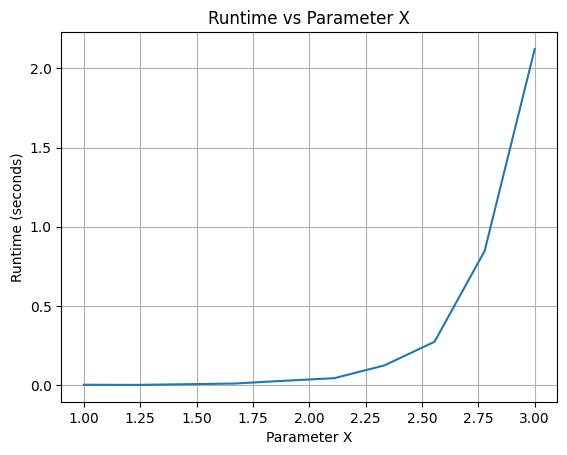

In [93]:
iterations = 3
runtime_values = np.zeros_like(y_values)
for j in range(len(y_values)):
        start_time = time.time()
        samples = lhs(20, samples=int(10**y_values[j]), criterion='maximin', iterations=iterations)
        end_time = time.time()
        tt = (end_time - start_time) / iterations
        print(f'Iterations={iterations}, samples={int(10**y_values[j])}, time = {tt}')
        runtime_values[j] = tt

# Plot contour map
plt.plot(y_values, runtime_values)
plt.xlabel('Parameter X')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs Parameter X')
plt.grid(True)
plt.show()

In [95]:
for p in runtime_values:
    print(p)

0.0016644795735677083
0.0004849433898925781
0.004779418309529622
0.009102582931518555
0.02660997708638509
0.043185154596964516
0.12392775217692058
0.2731184164683024
0.8468490441640218
2.1231815814971924


In [ ]:
x_values = np.linspace(10, 100, 10)
y_values = np.linspace(2, 3, 2)
X, Y = np.meshgrid(x_values, y_values)
x_values

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [ ]:
runtime_values = np.zeros_like(X)
for xxxi in range(len(x_vaclues)):
    for j in range(len(y_values)):
        start_time = time.time()
        samples = lhs(20, samples=int(10**y_values[j]), criterion='maximin', iterations=int(x_values[i]))
        # samples = lhs(int(x_values[i]+0.1), samples=int(10**y_values[j]), criterion='maximin', iterations=1)
        end_time = time.time()
        tt = (end_time - start_time) / x_values[i]
        print(f'Iterations={int(x_values[i])}, samples={int(10**y_values[j])}, time = {tt}')
        runtime_values[j, i] = tt

# Plot contour map
plt.figure()
contour_plot = plt.contourf(X, Y, runtime_values, cmap='viridis')
plt.colorbar(contour_plot, label='Runtime (seconds)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Runtime Contour Map')
plt.show()

Iterations=10, samples=100, time = 0.038462376594543456
Iterations=10, samples=1000, time = 2.3481754302978515
Iterations=20, samples=100, time = 0.023529088497161864
Iterations=20, samples=1000, time = 2.1654155254364014
Iterations=30, samples=100, time = 0.022002108891805015
Iterations=30, samples=1000, time = 2.229159140586853
Iterations=40, samples=100, time = 0.02432653307914734
Iterations=40, samples=1000, time = 2.3763138473033907
Iterations=50, samples=100, time = 0.02196399211883545
Iterations=50, samples=1000, time = 2.4172652530670167
Iterations=60, samples=100, time = 0.026031891504923504


KeyboardInterrupt: 